# **Experiment: Multiresolution induced by a $\Sigma$-multiplier**

This notebook reproduces results of the numerical experiments in

> D. Castelli Lacunza and C. A. Sing Long, "*Adaptive multipliers for frequency extrapolation*." January 28, 2025. [arXiv:2501.17019](https://doi.org/10.48550/arXiv.2501.17019).

You can use the following code to cite our work.

```bibtex
@misc{lacunza_adaptive_2025,
	title     = {Adaptive multipliers for extrapolation in frequency},
	doi       = {10.48550/arXiv.2501.17019},
	number    = {{arXiv}:2501.17019},
	publisher = {{arXiv}},
	author    = {Castelli Lacunza, Diego and Sing Long, Carlos A.},
	date      = {2025-01-28}}
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if "../.." not in sys.path:
    sys.path.insert(0, "../..")

SAVE_FIGURES = False

def savefig(fname):
  if SAVE_FIGURES:
    plt.savefig(f'FIG/E04_{fname:s}.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'FIG/E04_{fname:s}.eps', bbox_inches='tight')

## Contents
1. [Function collection](#function-collection)
2. [Multiplier](#multiplier)
3. [Optimal multiplier](#optimal-multiplier)
4. [Multiresolution](#multiresolution)

## Function collection

We define the functions that will generate the collection $\mathcal{F}$.

In [2]:
def rect_fourier(w, xo, a):
  return a * np.exp(-1j * 2 * np.pi * w * xo) * np.sinc(a * w)

def tri_fourier(w, xo, a):
  return a * np.exp(-1j * 2 * np.pi * w * xo) * np.sinc(a * w) ** 2

def rect(x, xo, a):
  return np.where(np.abs(x - xo) <= 0.5 * a, 1.0, 0.0)

def tri(x, xo, a):
  return np.maximum(0.0, 1.0 - np.abs(x - xo) / a)

Plot the generators for this experiment.

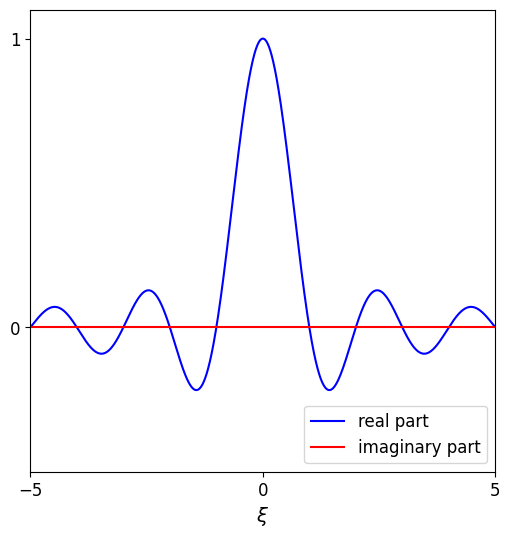

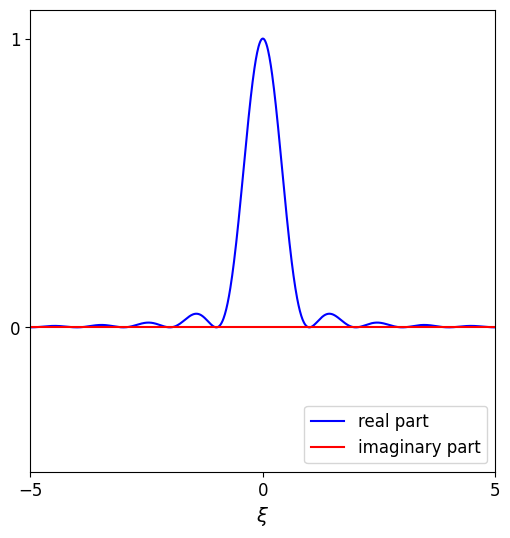

In [3]:
# frequency range
num_w = 1024
w_max = 5
w = np.linspace(-w_max, +w_max, num_w)

# plot
plt.figure(figsize=(6, 6))
plt.plot(w, rect_fourier(w, 0, 1).real, label='real part', color='b')
plt.plot(w, rect_fourier(w, 0, 1).imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
savefig('FILTER_SQR')
plt.legend(fontsize=12, loc='lower right')

plt.figure(figsize=(6, 6))
plt.plot(w, tri_fourier(w, 0, 1).real, label='real part', color='b')
plt.plot(w, tri_fourier(w, 0, 1).imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('FILTER_TRI')
plt.show()

## Multiplier

As an example consider the trace multiplier of this functions

In [4]:
from adaptiveExtrapolationInFrequency.objects.multiplier import SMultiplier
from adaptiveExtrapolationInFrequency.objects.domain import Square1D

Select $\Omega_0 = [-1/2, 1/2]$.

In [5]:
# domain
DS = Square1D(width = 1)
# selected domain for experiments
dom_mS = DS

Add the elements of the collection $\mathcal{F}$.

In [6]:
# create a multiplier for an empty collection
mS = SMultiplier(ndim = 1)
# add elements
mS.append(lambda w : rect_fourier(w, -1.3, 1.0))
mS.append(lambda w : tri_fourier(w, 0.2, 0.7))
mS.append(lambda w : rect_fourier(w, 3.4, 1.0))
mS.append(lambda w : tri_fourier(w, -0.2, 0.7))
# add domain
mS.domain = dom_mS

Plot the elements of the collection $\mathcal{U}$. The functions are two rect functions of width 1.0 centred at -1.3 and 3.4 respectively and two hat functions of width 0.7 and centered at -0.2 and 0.2 respectively.

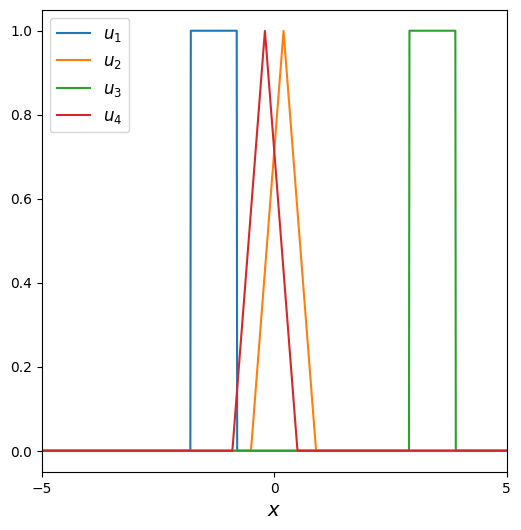

In [7]:
# spatial range
num_x = 1024
x_max = 5
x = np.linspace(-x_max, +x_max, num_x)

# plot space domain
plt.figure(figsize=(6, 6))
plt.plot(x, rect(x, -1.3, 1.0), label='$u_1$')
plt.plot(x, tri(x, 0.2, 0.7), label='$u_2$')
plt.plot(x, rect(x, 3.4, 1.0), label='$u_3$')
plt.plot(x, tri(x, -0.2, 0.7), label='$u_4$')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(x, rect(x, -1.3, 1.0), label='$u_1$')
plt.plot(x, tri(x, 0.2, 0.7), label='$u_2$')
plt.plot(x, rect(x, 3.4, 1.0), label='$u_3$')
plt.plot(x, tri(x, -0.2, 0.7), label='$u_4$')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ], fontsize=12)
plt.ylim([ -0.1, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
savefig('U_COLLECTION')
plt.close()

## Optimal multiplier

Compute the optimal multiplier for $\alpha = 2$.

In [8]:
from adaptiveExtrapolationInFrequency.objects.solver import FixedPointIteration
from adaptiveExtrapolationInFrequency.objects.projector import ProjSchattenLp

In [9]:
# instance of FPI
FPE = FixedPointIteration()
# set verbose = True
FPE.verbose = True

# projector
P = ProjSchattenLp(n = mS.size, p = np.inf)

In [10]:
# parameters
FPE.tG = 0.25
FPE.tS = 0.50

FPE.maxitns = 1000
FPE.print_every = 10
FPE.num_nodes_max = 100000
FPE.num_nodes_factor = 1.05

In [11]:
Sopt = FPE.solve(mS, P)

print('Optimal matrix:\n')
print(Sopt)

 itn      | obj(m)     | |x|       | |dx|      | nq     
        1 | +2.926E-01 | 2.000E+00 | 1.501E+00 |   1050
       10 | +1.625E-01 | 2.279E-01 | 7.194E-03 |   1628
       20 | +1.586E-01 | 2.317E-01 | 7.852E-03 |   2653
       30 | +1.576E-01 | 2.227E-01 | 4.739E-03 |   4321
       40 | +1.609E-01 | 2.303E-01 | 2.947E-03 |   7039
       50 | +1.621E-01 | 2.296E-01 | 2.424E-03 |  11467
       60 | +1.595E-01 | 2.279E-01 | 2.017E-03 |  18679
       70 | +1.590E-01 | 2.272E-01 | 2.001E-03 |  30426
       80 | +1.590E-01 | 2.263E-01 | 1.529E-03 |  49561
 itn      | obj(m)     | |x|       | |dx|      | nq     
       90 | +1.600E-01 | 2.272E-01 | 1.159E-03 |  80730
      100 | +1.597E-01 | 2.273E-01 | 1.295E-03 | 100000
      110 | +1.605E-01 | 2.281E-01 | 5.095E-04 | 100000
      120 | +1.603E-01 | 2.275E-01 | 6.462E-04 | 100000
      130 | +1.597E-01 | 2.277E-01 | 8.530E-04 | 100000
      140 | +1.597E-01 | 2.270E-01 | 1.410E-03 | 100000
      150 | +1.594E-01 | 2.271E-01 | 8.353E-04

Define the optimal multiplier.

In [12]:
# for first-order window
mS.domain.delta = 5E-2
# multiplier
mS_eval_windowed = lambda w : mS.eval_windowed(Sopt, w)

Plot the inverse Fourier transform of the optimal multiplier.

In [13]:
from adaptiveExtrapolationInFrequency.routines.integrals import inverse_fourier_transform_1d

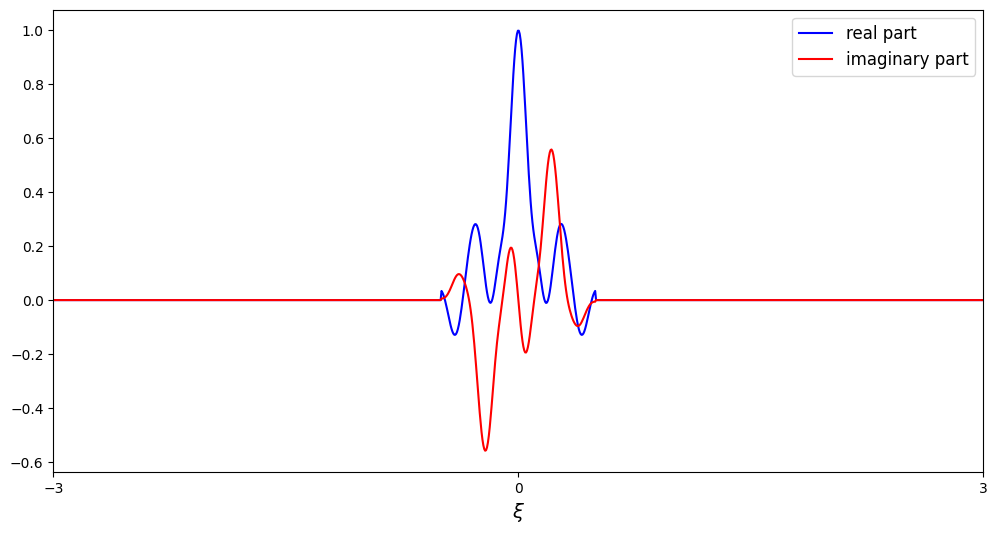

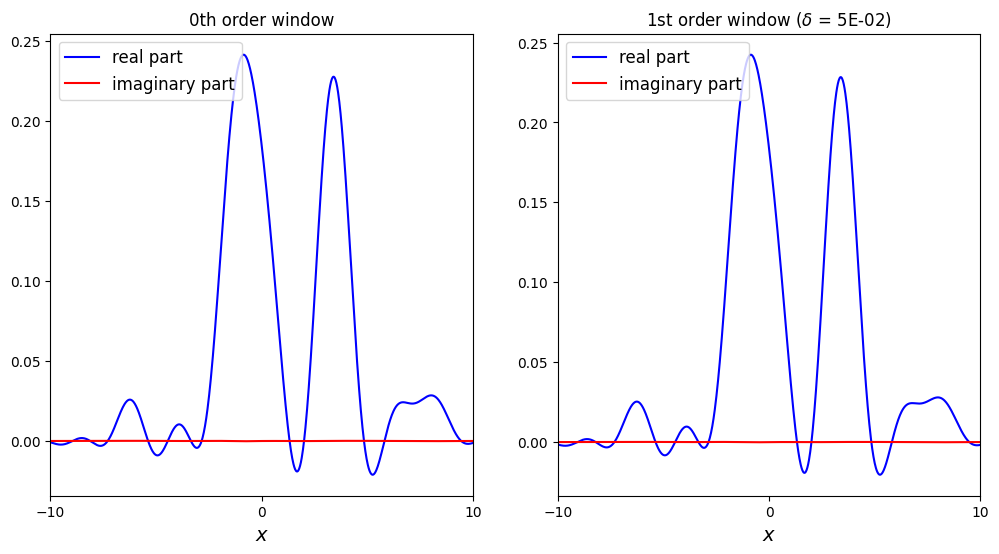

In [14]:
# frequency range
num_w = 1024
w_max = 3
w = np.linspace(-w_max, +w_max, num_w)

# spatial range
num_x = 1024
x_max = 10
x = np.linspace(-x_max, +x_max, num_x)

# 0th order window
mS.domain.window = 'zeroth_order'
mS_w = mS_eval_windowed(w)
u_x = inverse_fourier_transform_1d(mS_eval_windowed, x, 0.5 * mS.domain.width, 2048)

# 1st order window
mS.domain.window = 'first_order'
us_x = inverse_fourier_transform_1d(mS_eval_windowed, x, 0.5 * mS.domain.width, 2048)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.plot(w, mS_w.real, label='real part', color='b')
plt.plot(w, mS_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.show()

# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, u_x.real, label='real part', color='b')
plt.plot(x, u_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.title('0th order window')
plt.subplot(1, 2, 2)
plt.plot(x, us_x.real, label='real part', color='b')
plt.plot(x, us_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.title(f'1st order window ($\\delta$ = {mS.domain.delta:.0E})')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, mS_w.real, label='real part', color='b')
plt.plot(w, mS_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -1.1, +1.1 ])
plt.yticks([ -1.0, 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('MS')
plt.close()

plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(x, u_x.real, label='real part', color='b')
plt.plot(x, u_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('MS_X')
plt.close()

## Multiresolution

Construct the functions that induce a multiresolution. For this, we import the following functions. In each case, $m$ represents the **1-periodization** of multiplier induced by the family $\mathcal{F}$. If $m_{\Sigma}$ is the multiplier induced by $\Sigma$ then
$$
  m(\xi) = m_{\Sigma}\left(\left(x+\frac{1}{2} \mod 1\right) -\frac{1}{2}\right).
$$

The functions are:
- ``phi_N`` is the approximation to a refinable function constructed using the the truncated cascade algorithm
$$\hat{\phi}_N(\xi) = \prod_{j=1}^{N} m(2^{-j}\xi) $$
- ``Phi_NK`` is the approximation to the periodization of $\widehat{\phi}_N$ with $2K + 1$ translates
$$\Phi_{N,K}(\xi) = \sum_{k = -K}^K |\widehat{\phi}_N(\xi - k)|^2 \approx \sum_{k\in \mathbb{Z}}|\widehat{\phi}_{\infty}(\xi - k)|^2$$
- ``g_NK`` is the wavelet mask given by
$$g_{N,K}(\xi) = m\left(\xi + \frac{1}{2}\right)^{*} \Phi_{N,K}\left(\xi + \frac{1}{2}\right) e^{-2\pi i \xi}$$
- ``psi_NK`` is the approximation to the associated wavelet given by
$$\widehat{\psi}_{N,K}(\xi) = g_{N,K}\left(\frac{\xi}{2}\right) \widehat{\phi}_N\left(\frac{\xi}{2}\right)$$

In [15]:
from adaptiveExtrapolationInFrequency.routines.multiresolution import phi_N, Phi_NK, g_NK, psi_NK

Plot $\widehat{\phi}_N$ and $\phi_N$.

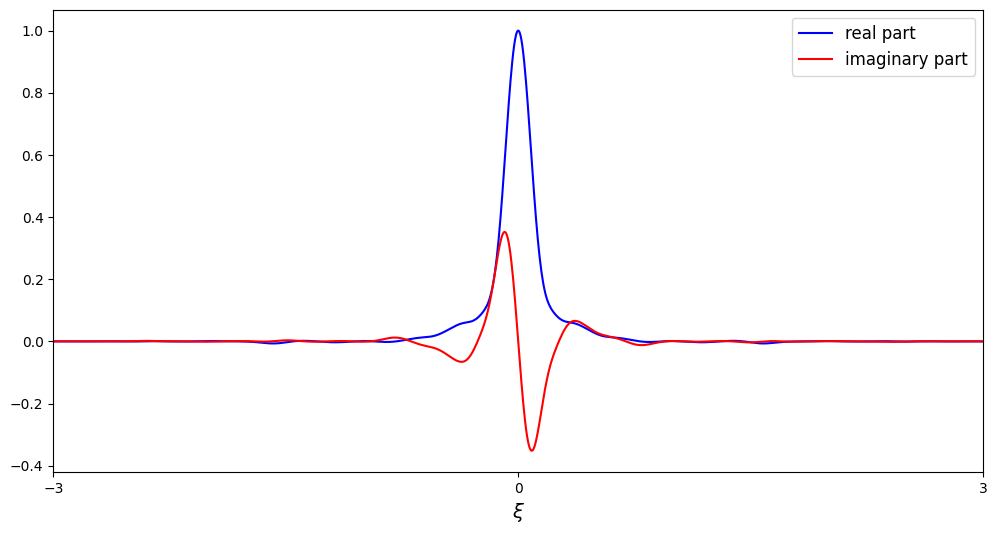

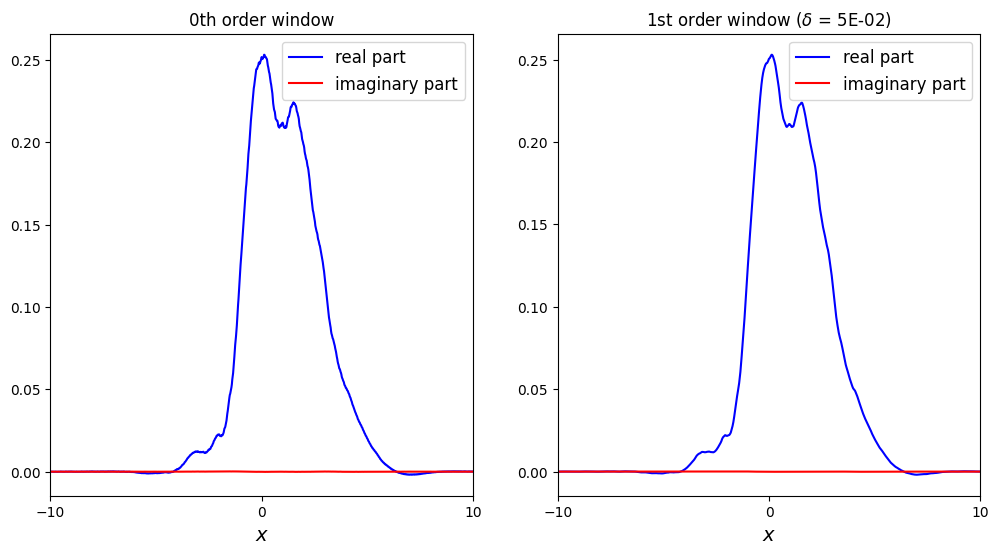

In [16]:
# 0th order window
mS.domain.window = 'zeroth_order'
phi_N_hat_w = phi_N(mS_eval_windowed, N=128)(w)
phi_N_x = inverse_fourier_transform_1d(phi_N(mS_eval_windowed, N=128), x,  2**4 * mS.domain.width, 2048)
# 1st order window
mS.domain.window = 'first_order'
phis_N_x = inverse_fourier_transform_1d(phi_N(mS_eval_windowed, N=128), x, 2**4 * mS.domain.width, 2048)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.plot(w, phi_N_hat_w.real, label='real part', color='b')
plt.plot(w, phi_N_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.show()

# plot space domain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, phi_N_x.real, label='real part', color='b')
plt.plot(x, phi_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.subplot(1, 2, 2)
plt.plot(x, phis_N_x.real, label='real part', color='b')
plt.plot(x, phis_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title(f'1st order window ($\\delta$ = {mS.domain.delta:.0E})')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, phi_N_hat_w.real, label='real part', color='b')
plt.plot(w, phi_N_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -1.1, +1.1 ])
plt.yticks([ -1.0, 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PHI_N_HAT')
plt.close()

plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(x, phi_N_x.real, label='real part', color='b')
plt.plot(x, phi_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ], fontsize=12)
plt.ylim([ -0.1, +0.3 ])
plt.yticks([ 0.0, 0.25 ], fontsize=12)
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PHI_N')
plt.close()


Plot the periodization $\Phi_{N,K}$.

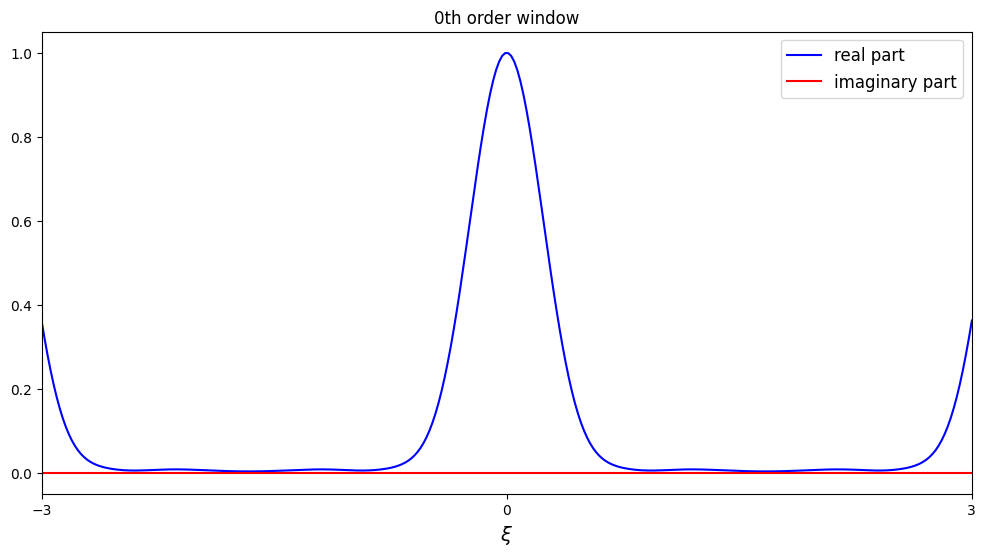

In [17]:
# zeroth-order window
mS.domain.window = 'zeroth_order'
Phi_NK_w = Phi_NK(w, mS_eval_windowed, N=128, K=256)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.plot(x, Phi_NK_w.real, label='real part', color='b')
plt.plot(x, Phi_NK_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, Phi_NK_w.real, label='real part', color='b')
plt.plot(w, Phi_NK_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PPHI_NK_HAT')
plt.close()

Plot the wavelet mask $g_{N,K}$.

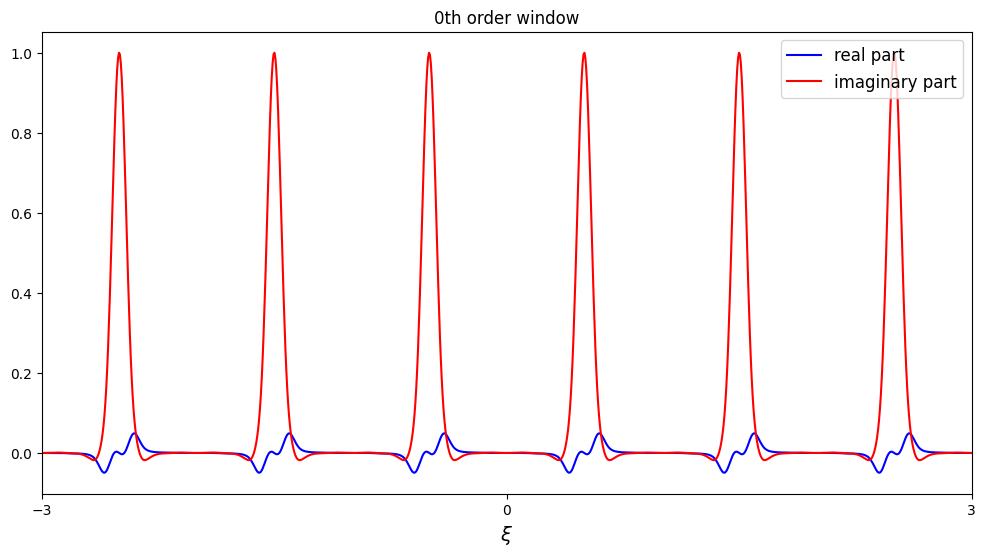

In [18]:
# 0th order window
mS.domain.window = 'zeroth_order'
g_NK_w = g_NK(w, mS_eval_windowed, N=128, K=256)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.plot(w, g_NK_w.real, label='real part', color='b')
plt.plot(w, g_NK_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, g_NK_w.real, label='real part', color='b')
plt.plot(w, g_NK_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -1.1, +0.5 ])
plt.yticks([ -1, 0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
savefig('G_NK_HAT')
plt.close()

Finally, plot $\widehat{\psi}_{N,K}$ and $\psi_{N,K}$.

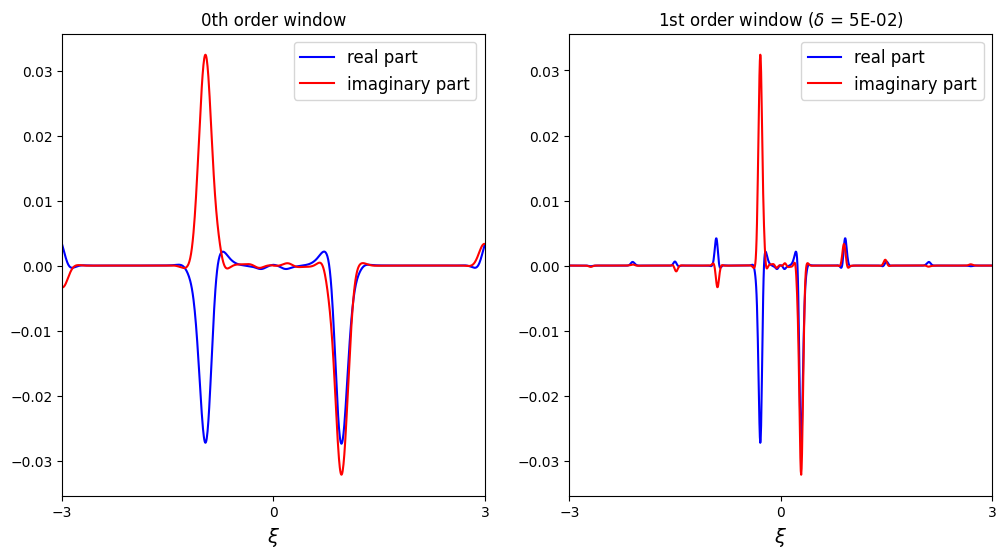

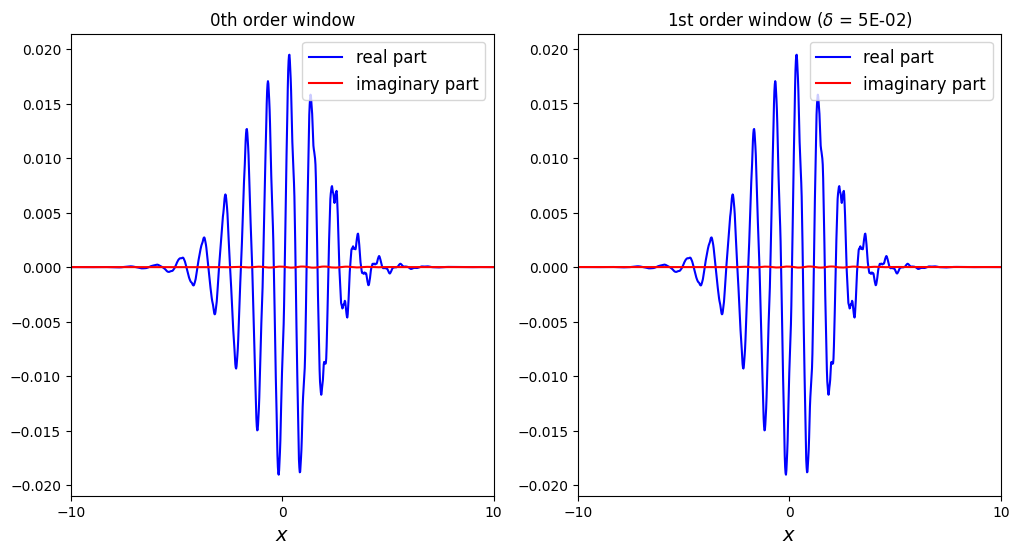

In [19]:
# phase
psi_ph = np.exp(1j * np.pi * 0.5)
# 0th order window
mS.domain.window = 'zeroth_order'
psi_NK_hat_w = psi_NK(mS_eval_windowed, psi_0=psi_ph, N=128, K=256)(w)
psi_NK_x = inverse_fourier_transform_1d(psi_NK(mS_eval_windowed, psi_0=psi_ph, N=128, K=256), x,  2**4 * mS.domain.width, 2048)
# 1st order window
mS.domain.window = 'first_order'
psis_N_hat_w = psi_NK(mS_eval_windowed, psi_0=psi_ph, N=128, K=256)(x)
psis_N_x = inverse_fourier_transform_1d(psi_NK(mS_eval_windowed, psi_0=psi_ph, N=128, K=256), x, 2**4 * mS.domain.width, 2048)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(w, psi_NK_hat_w.real, label='real part', color='b')
plt.plot(w, psi_NK_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.subplot(1, 2, 2)
plt.plot(w, psis_N_hat_w.real, label='real part', color='b')
plt.plot(w, psis_N_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title(f'1st order window ($\\delta$ = {mS.domain.delta:.0E})')
plt.show()

# plot space domain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, psi_NK_x.real, label='real part', color='b')
plt.plot(x, psi_NK_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.subplot(1, 2, 2)
plt.plot(x, psis_N_x.real, label='real part', color='b')
plt.plot(x, psis_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title(f'1st order window ($\\delta$ = {mS.domain.delta:.0E})')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, psi_NK_hat_w.real, label='real part', color='b')
plt.plot(w, psi_NK_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.11, +0.11 ])
plt.yticks([ -0.1, 0.0, 0.1 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PSI_NK_HAT')
plt.close()

plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(x, psi_NK_x.real, label='real part', color='b')
plt.plot(x, psi_NK_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ], fontsize=12)
plt.ylim([ -0.03, +0.03 ])
plt.yticks([ -0.025, 0.0, 0.025 ], fontsize=12)
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PSI_NK')
plt.close()

We can plot the refinable function and wavelet associated to this optimal multiplier.

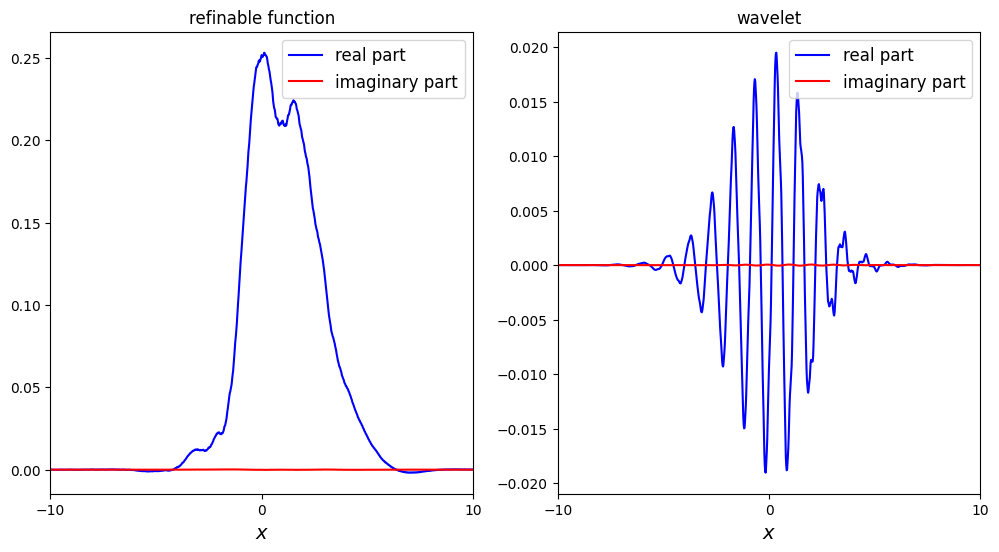

In [20]:
# plot space domain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, phi_N_x.real, label='real part', color='b')
plt.plot(x, phi_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('refinable function')
plt.subplot(1, 2, 2)
plt.plot(x, psi_NK_x.real, label='real part', color='b')
plt.plot(x, psi_NK_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('wavelet')
plt.show()